### Final project  
### Wind predictor "WeDOON"  
### For wind farms and single generator  


  
    
  
для решения необходимо задать  
широту, долготу и альтитуду  
места установки ветрогенератора

  
*направление ветра - откуда дует, т.е. ветер 180 градусв, означает - дует с юга

In [17]:
# uncomment for manual entry

# lat_test = float(input('enter lattitude ')) # in format xx.xxxx (deg)
# lon_test = float(input('enter longitude ')) # in format xx.xxxx (deg)
# alt_test = int(input('enter altitude ')) # in format xx (m)


в учебных целях используются координаты м.Таран в Калининградской области,  
не затенено поверхностью порядка 300 градусов,  
место открыто для всех преобладающих ветров в данном регионе  

In [18]:
lat_test = 54.9593
lon_test = 19.9893
alt_test = 30

библиотека folium, для отображения карты

In [19]:
import folium
poi = folium.Map(location=[lat_test, lon_test], zoom_start=7,
                width=900, height=500)
folium.Marker([lat_test, lon_test],
             icon=folium.Icon(color="red")).add_to(poi)
poi

In [20]:
# lat_train =
# lon_train = 
# alt_train =

In [21]:
# lat_test, lon_test, alt_test

по географическим данным можем получить ближайшую метеостанцию,  
которая выдает почасовые данные  
устанавливаем и импортируем библиотеку meteostat  
также необходима библиотека datetime для работы со временем  

библиотека meteostat еще удобна тем, что выводит данные сразу в DataFrame,  
нет необходимости обрабатывать запросы и ответы по API,
хотя и API так же имеется

In [22]:
# pip install meteostat
import meteostat
from meteostat import Stations
from datetime import datetime

### meteostat library is provided by:  
https://dev.meteostat.net/  

### Quota  
Free access to the Meteostat API is  
### limited to 2,000 requests per day and no more than two requests per second.  
Once this limit is reached, all of your requests will result in HTTP 429, too many requests, until your quota is cleared.  

достаточно для целей проекта


In [23]:
# help(meteostat)

список станций, передающих данные ежечасно на указанную дату

In [24]:
st = Stations()
st = st.inventory('hourly', datetime(2021,1,1))
# st.fetch()['region'].value_counts()
st_1 = st.fetch()
st.fetch().shape

(10325, 13)

на 1/01/2021 работало 10325 метеостанций по всему миру

описание данных:  
id - идентификатор WMO (World Meteoroligical Organization, Всемирная метеорологическая организация)  
name - английское название метеостанции  
country - страна, согласно ISO 3166-1 alpha-2 country code of the weather station  
region - регион - согласно ISO  3166-2 state or region code of the weather station  
wmo - см. id  
icao - International Civil Aviation Organization (Международная Организация Гражданской Авиации) - если станция установлена в аэропорту        
latitude - широта метеостанции  
longitude - долготоа метеостанции  
elevation - высота метеостанции над уровнем моря  
timezone - временная зона  
hourly_start - дата начала передачи метео данных в почасовом режиме  
hourly_end - дата окончания передачи метео данных в почасовом режиме  
daily_start - датат начала передачи данных в суточном режима  
daily_end - дата окончания передачи данных в суточном режиме  

In [25]:
st.fetch().head()

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end
id,,,,,,,,,,,,,
01001,Jan Mayen,NO,<NA>,01001,ENJA,70.9333,-8.6667,10.0,Europe/Oslo,1955-01-01,2021-03-02,1922-01-01,2021-02-10
01003,Hornsund,NO,<NA>,01003,<NA>,77.0000,15.5000,10.0,Europe/Oslo,1985-06-01,2021-03-01,NaT,NaT
01008,Svalbard Lufthavn,NO,<NA>,01008,ENSB,78.2500,15.4667,2.0,Europe/Oslo,1975-09-29,2021-03-02,1975-08-01,2021-02-10
01010,Andoya,NO,NO,01010,ENAN,69.3000,16.1500,1.0,Europe/Oslo,1973-01-01,2021-03-01,2015-09-07,2018-12-28
01015,Hekkingen Lighthouse,NO,TR,01015,<NA>,69.6000,17.8333,14.0,Europe/Oslo,1980-03-14,2021-03-01,1979-11-01,2021-02-10


получим список метеостанций, рядом с интересующим местом,  
в радиусе 100 км  
при избыточном количестве метеосатнций, можно ограничить вывод,  
указаав требуемое количество в методе fetch(n)   
n - требуемое количество метеостанций,  
метод выводит n самых ближайших, отсортировано по расстоянию

In [26]:
dist_test = 100000 # in meters
near_ = st.nearby(lat_test, lon_test, dist_test).fetch()
near_

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,distance
id,,,,,,,,,,,,,,
26702,Kaliningrad,RU,KGD,26702,UMKK,54.7167,20.5500,27.0,Europe/Kaliningrad,1955-01-01,2021-03-02,1931-01-01,2021-02-10,44909.570165
26603,Nida,LT,KP,26603,<NA>,55.3167,21.0167,2.0,Europe/Vilnius,2018-01-28,2021-03-02,1959-01-01,2014-09-08,76443.047043
12135,Hel,PL,PM,12135,<NA>,54.6000,18.8167,1.0,Europe/Warsaw,1955-07-01,2021-03-02,NaT,NaT,85151.691663
12160,Elblag,PL,WM,12160,EPEL,54.1667,19.4333,40.0,Europe/Warsaw,1953-01-02,2021-03-02,1936-01-03,2021-02-10,95144.078495
12155,Gdansk-Swibno,PL,PM,12155,<NA>,54.3333,18.9333,7.0,Europe/Warsaw,1982-09-01,2021-03-01,NaT,NaT,97270.314253


для моделирования будут использоваться данные метеостанции,  
расположенной в аэропорту Храброво (icao = UMKK),  
как наиболее близкорасположенная к объекту исследования  

по остальным станциям будет проводится учеба и оценка модели

In [27]:
st.nearby(lat_test, lon_test, dist_test).fetch(1)

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,distance
id,,,,,,,,,,,,,,
26702,Kaliningrad,RU,KGD,26702,UMKK,54.7167,20.55,27.0,Europe/Kaliningrad,1955-01-01,2021-03-02,1931-01-01,2021-02-10,44909.570165


получим время начала записи ежечасных данных,  
как максимум по hourly_start

In [28]:
for_date = st.nearby(lat_test, lon_test, dist_test).fetch()
start = for_date['hourly_start'].max()

now = datetime.now().strftime('%Y,%m,%d %H:%M')

end = datetime.strptime(now,'%Y,%m,%d %H:%M' )
# start.date(), now, end

In [29]:
from meteostat import Hourly

data = Hourly('26702', start, end)
data = data.fetch()
data

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2018-01-28 00:00:00,3.0,1.7,91.0,NaN,NaN,180.0,3.6,NaN,1025.7,NaN,4.0
2018-01-28 01:00:00,3.0,2.0,93.0,NaN,NaN,180.0,18.0,NaN,1023.0,NaN,NaN
2018-01-28 02:00:00,3.0,2.0,93.0,NaN,NaN,190.0,18.0,NaN,1022.0,NaN,NaN
2018-01-28 03:00:00,3.0,1.0,87.0,NaN,NaN,190.0,7.2,NaN,1021.1,NaN,NaN
2018-01-28 04:00:00,3.0,2.0,93.0,NaN,NaN,170.0,21.6,NaN,1018.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-21 15:00:00,6.9,1.6,69.0,0.0,NaN,206.0,5.5,14.8,1021.7,NaN,2.0
2021-02-21 16:00:00,6.2,1.5,72.0,0.0,NaN,209.0,3.7,14.8,1022.0,NaN,2.0
2021-02-21 17:00:00,5.4,1.3,75.0,0.0,NaN,212.0,3.7,14.8,1022.2,NaN,2.0


описание данных:  
temp - температура воздуха в градусах Цельсия  
dwpt - точка росы в градусах Цельсия  
rhum - относительная влажность в %  
prcp - осадки в час, в мм   
snow - глубина снежного покрова в мм  
wdir - направление ветра в градусах  
wspd - скорость ветра в км/ч    
wpgt - пиковая скорость ветра в порывах в км/ч   
press - давление в hPa  
tsun - солнечно в течение часа в минутах  
coco - код условий погоды, см.ссылку ниже  

https://dev.meteostat.net/docs/formats.html#weather-condition-codes


In [30]:
lat_neighb = list(near_['latitude'][1:])
lon_neighb = list(near_['longitude'][1:])

In [31]:
for latd, lngt in zip(lat_neighb, lon_neighb):
    folium.Marker([latd,lngt]).add_to(poi)


# nearest
folium.Marker([near_['latitude'][0], near_['longitude'][0]],
              icon=folium.Icon(color="green")).add_to(poi)
poi

In [32]:
# help(folium)

In [85]:
id_station = near_['wmo']
id_station[0]

'26702'

In [86]:
data = Hourly('72219', start, end)
data = data.fetch()

In [244]:
data['wspd'] = data['wspd'] / 3.6
data.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2020-02-21 20:00:00,3.0,0.2,82.0,NaN,NaN,200.0,0.833333,NaN,1020.2,NaN,NaN
2020-02-21 21:00:00,2.4,0.0,84.0,NaN,NaN,190.0,1.111111,NaN,1020.0,NaN,NaN
2020-02-21 22:00:00,2.0,0.1,87.0,NaN,NaN,200.0,1.111111,NaN,1019.5,NaN,NaN
2020-02-21 23:00:00,1.6,0.0,89.0,NaN,NaN,200.0,1.111111,NaN,1019.4,NaN,NaN
2020-02-22 00:00:00,1.7,0.2,90.0,NaN,NaN,190.0,1.111111,NaN,1019.3,NaN,NaN


In [260]:
import pandas as pd
# wind_cond = pd.DataFrame(columns=['wspd_sum','wdir_sum'])
wind_cond = pd.DataFrame()
# wind_cond[[f'wspd_{id_station[0]}', f'wdir_{id_station[0]}' ]] = data[['wspd','wdir']]
# wind_cond.mean()


In [261]:
# wind_cond.isna().sum()

In [262]:
# wind_cond.ffill().describe()

In [263]:
# len(wind_cond) / 24 / 365

In [264]:
# for st in id_station:
#     data = Hourly(st, start, end).fetch()
#     data['wspd'] = data['wspd'] / 3.6 # from km/h to m/s
#     wind_cond[[f'wspd_{st}', f'wdir_{st}' ]] = data[['wspd', 'wdir']].ffill()
    

# wind_cond.describe()

In [265]:
from dateutil.relativedelta import relativedelta

start_ = end + relativedelta(years= -1)
start_

datetime.datetime(2020, 2, 21, 19, 7)

In [266]:
for st in id_station:
    data = Hourly(st, start_, end).fetch()
    data['wspd'] = data['wspd'] / 3.6 # from km/h to m/s
    wind_cond[[f'wspd_{st}', f'wdir_{st}' ]] = data[['wspd', 'wdir']].ffill()

wind_cond.describe()

,wspd_26702,wdir_26702,wspd_26603,wdir_26603,wspd_12135,wdir_12135,wspd_12160,wdir_12160,wspd_12155,wdir_12155
count,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,3190.000000,3190.000000
mean,2.139768,190.176799,4.344006,188.866120,4.337258,197.817509,4.149774,194.655852,4.403065,193.954232
std,1.820242,95.234301,1.659127,93.505379,1.658564,94.498214,1.743576,92.166019,2.255247,94.735679
min,0.000000,0.000000,0.500000,1.000000,1.000000,1.000000,0.000000,0.000000,0.388889,0.000000
25%,1.027778,122.000000,3.083333,130.000000,3.083333,134.000000,3.000000,138.000000,3.000000,130.000000
50%,1.527778,200.000000,4.111111,192.000000,4.111111,204.000000,4.000000,204.000000,4.000000,196.000000
75%,2.583333,261.000000,5.666667,251.000000,5.138889,271.000000,5.138889,250.000000,6.000000,266.000000
max,17.000000,360.000000,10.277778,360.000000,17.000000,360.000000,13.000000,360.000000,15.000000,360.000000


списки с колонками скоростей ветра и направлением ветра, по окружению

In [268]:
col_list_dir = []
col_list_spd = []
for c in range(len(wind_cond.columns)):
    if c % 2:
        col_list_dir.append(wind_cond.columns[c])
    else:
        col_list_spd.append(wind_cond.columns[c])
        
# col_list_spd, col_list_dir

In [285]:
wind_cond[col_list_dir].describe()

,wdir_26702,wdir_26603,wdir_12135,wdir_12160,wdir_12155
count,8784.000000,8784.000000,8784.000000,8784.000000,3190.000000
mean,190.176799,188.866120,197.817509,194.655852,193.954232
std,95.234301,93.505379,94.498214,92.166019,94.735679
min,0.000000,1.000000,1.000000,0.000000,0.000000
25%,122.000000,130.000000,134.000000,138.000000,130.000000
50%,200.000000,192.000000,204.000000,204.000000,196.000000
75%,261.000000,251.000000,271.000000,250.000000,266.000000
max,360.000000,360.000000,360.000000,360.000000,360.000000


In [286]:
wind_cond[col_list_spd].describe()

,wspd_26702,wspd_26603,wspd_12135,wspd_12160,wspd_12155
count,8784.000000,8784.000000,8784.000000,8784.000000,3190.000000
mean,2.139768,4.344006,4.337258,4.149774,4.403065
std,1.820242,1.659127,1.658564,1.743576,2.255247
min,0.000000,0.500000,1.000000,0.000000,0.388889
25%,1.027778,3.083333,3.083333,3.000000,3.000000
50%,1.527778,4.111111,4.111111,4.000000,4.000000
75%,2.583333,5.666667,5.138889,5.138889,6.000000
max,17.000000,10.277778,17.000000,13.000000,15.000000


средняя скорость ветра по окружению

In [353]:
round(wind_cond[col_list_spd].mean().mean(),1)

3.9

75% времени скорость ветра:

In [351]:
round(wind_cond[col_list_spd].quantile(.75).mean())

5

преобадающее направление ветра

In [352]:
round(wind_cond[col_list_dir].quantile(.75).mean())

260

количество дней в году (по окружению) со скоростью ветра, меньше 2 м/с,  
что является нижней границей работоспособности ветрогенератора  

In [350]:
d = wind_cond[col_list_spd][wind_cond[col_list_spd] < 2].count(axis=0).mean()/len(wind_cond)*100
print(f'{round(d,1)}'+ "%")

13.4%


In [337]:
round(365 * d /100)

49

полтора месяца в году можно использовать для ремонтных и профилактических работ на установках

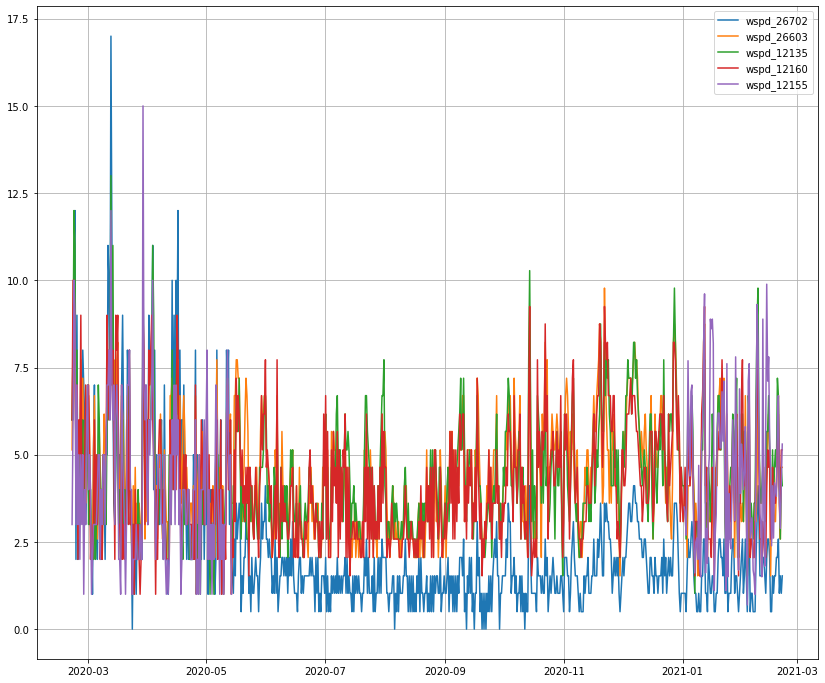

In [380]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,12))
plt.plot(wind_cond[col_list_spd][::12])
plt.legend(col_list_spd)
plt.grid()
plt.show()

In [383]:
# библиотека для построения розы ветров (направление, скорость ветра)
# pip install windrose

In [388]:
ws = wind_cond[col_list_spd].mean(axis=1)
wd = wind_cond[col_list_dir].mean(axis=1)

In [390]:
from windrose import WindroseAxes
import matplotlib.cm as cm

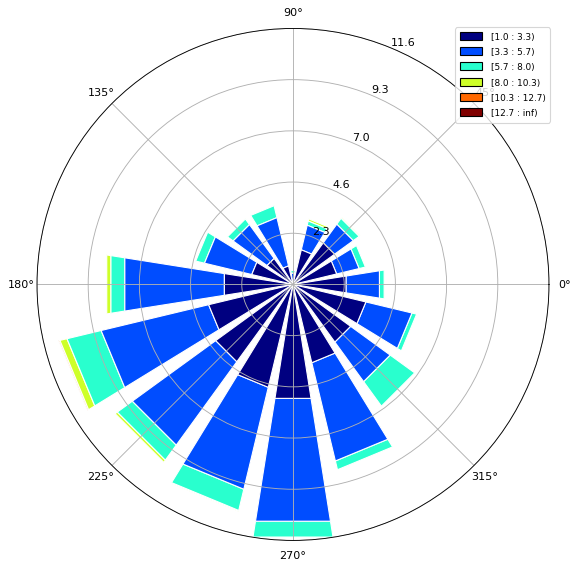

In [402]:
ax = WindroseAxes.from_ax()
ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white')
ax.set_legend(loc='upper right')